# Twitter data analysis in Python

Select twitter account, analyze latest tweets and display info in meaningful graphs.

Requires: 
    twitter developer account (consumer key and secret and access token)

Results:
    Most rewteeted and favorited tweets
    Source analysis
    Links frecuency in tweets
    weekly distribution


### Set twitter account to be analyzed (screen_name)

In [1]:
tw_account = 'gabrielrufian'

### Create a credentials.py file including:
    # Twitter APP access keys
    
    # Consume
    CONSUMER_KEY ='xxxxxxxxxxxxxxxxxxxxxxxx'
    CONSUMER_SECRET='xxxxxxxxxxxxxxxxxxxxxxxxx'
    
    # Access
    ACCESS_TOKEN='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
    ACCESS_SECRET='xxxxxxxxxxxxxxxxxxxxxxxx'

In [2]:
from credentials import *

def twitter_setup():
    auth = tweepy.OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN,ACCESS_SECRET)
    
    api = tweepy.API(auth)
    return api

### Imports

In [3]:
import tweepy
import pandas as pd
import numpy as np
import collections
import urllib.parse as parse

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
### Read tweets from user account using tweepy
#Create API object
api = twitter_setup()

tweets=[]

for tweet in tweepy.Cursor(api.user_timeline,screen_name=tw_account).items():
    tweets.append(tweet)

print('Number of tweets {}.\n'.format(len(tweets)))

Number of tweets 3155.



In [5]:
def first_item(list_or_none):
    if list_or_none: return list_or_none[0]["expanded_url"]

In [6]:
### Create a Pandas dataframe

data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
data['ID']=np.array([tweet.id for tweet in tweets])
data['Date']=np.array([tweet.created_at for tweet in tweets])
data['Likes']=np.array([tweet.favorite_count for tweet in tweets])
data['RTs']=np.array([tweet.retweet_count for tweet in tweets])
data['length']=np.array([len(tweet.text) for tweet in tweets])
data['Source']=np.array([tweet.source for tweet in tweets])
urls = [tweet.entities["urls"] for tweet in tweets]
data['Url']=np.array([first_item(url) for url in urls])
#display(data.head(10))

In [7]:
# Get the most liked and retweeted tweet:
fav_max = np.max(data['Likes'])
rt_max  = np.max(data['RTs'])

fav = data[data.Likes == fav_max].index[0]
rt  = data[data.RTs == rt_max].index[0]

# Most lked tweet:
print("Most liked tweet is: \n{}".format(data['Tweets'][fav]))
print("Number of likes: {}".format(fav_max))

# Most retweeted tweet:
print("Most retweeted tweet is: \n{}".format(data['Tweets'][rt]))
print("Number of RTs: {}".format(rt_max))

Most liked tweet is: 
Se ha sacado a Franco del Valle de los Caídos y se ha metido en la Junta de Andalucía.
Number of likes: 41520
Most retweeted tweet is: 
RT @AOC: I hear the GOP thinks women dancing are scandalous.

Wait till they find out Congresswomen dance too! 💃🏽

Have a great weekend eve…
Number of RTs: 159218


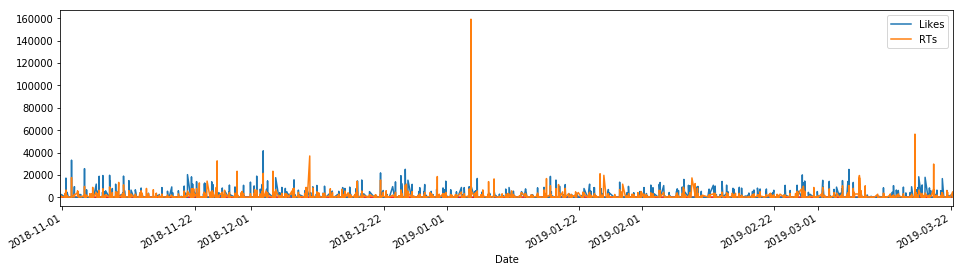

In [8]:
# Likes and retweets per date

tlen = pd.Series(data=data['length'].values, index=data['Date'])
tfav = pd.Series(data=data['Likes'].values, index=data['Date'])
tret = pd.Series(data=data['RTs'].values, index=data['Date'])
# Variación de las longitudes de tweets con el tiempo:
tlen.plot(figsize=(16,4), color='r');

# Visualización de Me gusta vs Retuits:

tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="RTs", legend=True);

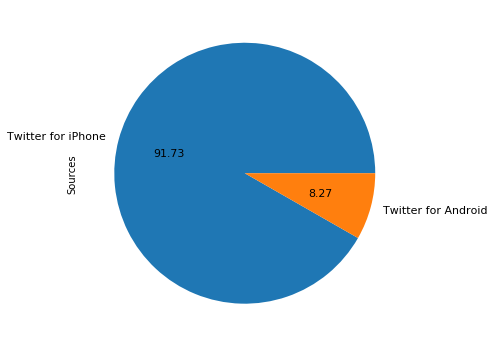

In [9]:
# Get the set of sources:
sources = []
for source in data['Source']:
    if source not in sources:
        sources.append(source)
        

# Create a numpy vector with source labels:
percent = np.zeros(len(sources))

for source in data['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

# Pie Graph:
pie = pd.Series(percent, index=sources, name='Sources')
pie.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));



In [10]:
# Get list of first 'expanded' URL in tweet
expanded_urls=[first_item(url) for url in urls]

#Parse the URL to get the server and clean up empty links or linkt to tweets
hosts = [parse.urlsplit(url).netloc for url in expanded_urls]
remove_hosts = [b'', 'twitter.com']
clean_hosts = [host for host in hosts if not host in remove_hosts]

#Create a collection counter of links to select and count most common linnks
count_hosts = collections.Counter(clean_hosts)


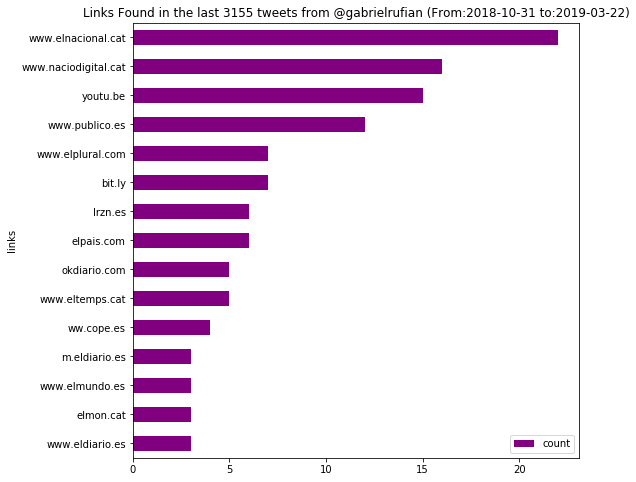

In [11]:
#Based on the counter, create a Pandas Dataframe for analysis and plotting that includes only the top 15 most common links.
clean_hosts_pd = pd.DataFrame(count_hosts.most_common(15),
                             columns=['links', 'count'])

#Using this Pandas Dataframe, create a horizontal bar graph of the top 15 most common words in the tweets as shown below.
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_hosts_pd.sort_values(by='count').plot.barh(x='links',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title('Links Found in the last ' + format(len(tweets)) + ' tweets from @' + tw_account + ' (From:' +np.min(data['Date']).date().isoformat() + ' to:'+np.max(data['Date']).date().isoformat()+')')

plt.savefig('results/Links from @'+tw_account+'.png')

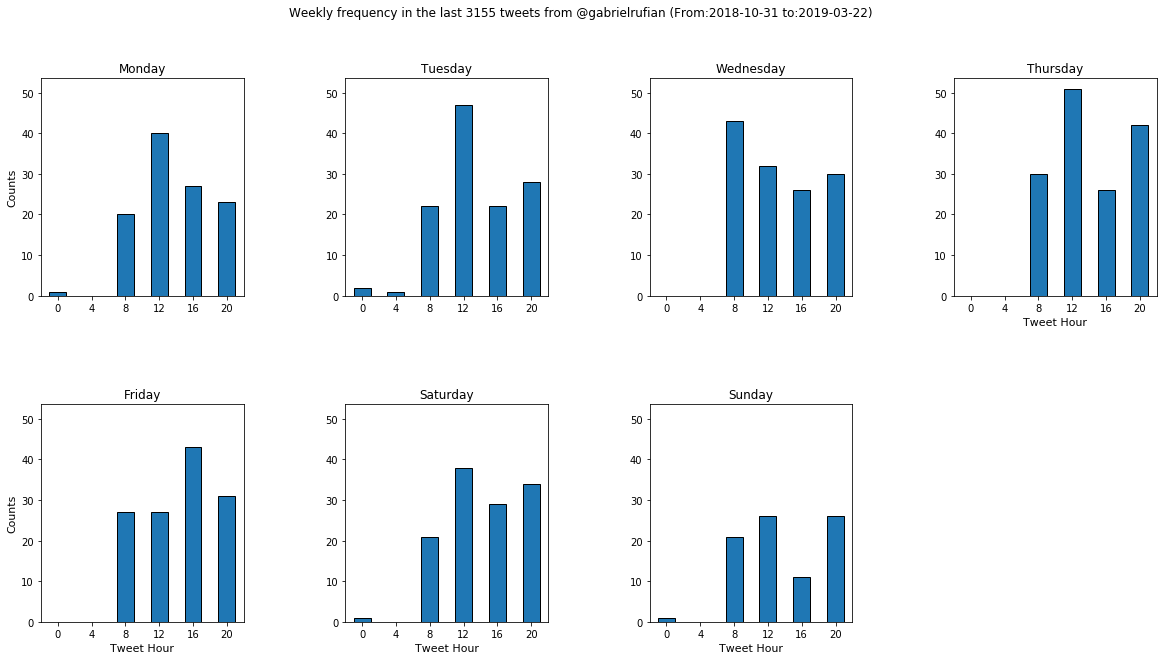

In [12]:
### Weekly distribution

data['dow'] = data.Date.dt.dayofweek
data['hour'] = data.Date.dt.hour

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
fig.delaxes(ax[1,3])  #7 days in a week, remove 8th panel
ax = ax.flatten()  #Far easier to work with a flattened array


lsize=8
plt.subplots_adjust(wspace=0.5, hspace=0.5)  #Remove some whitespace between subplots

for idx, gp in data.groupby(data.Date.dt.dayofweek):
    ax[idx].set_title(gp.Date.dt.day_name().iloc[0])  #Set title to the weekday

    (gp.groupby(gp.Date.dt.hour).size().rename_axis([None]).to_frame()
        .reindex(np.arange(0,24,4)).fillna(0)
        .plot(kind='bar', ax=ax[idx], rot=0, ec='k', legend=False))

    # Titles on correct panels
    if idx%4 == 0:
        _ = ax[idx].set_ylabel('Counts', fontsize=11)
    if (idx//4 == 1) | (idx%4 == 3):
        _ = ax[idx].set_xlabel('Tweet Hour', fontsize=11) 



# Consistent bounds between subplots. 
lb, ub = list(zip(*[axis.get_ylim() for axis in ax]))
for axis in ax:
    axis.set_ylim(min(lb), max(ub)) 

plt.suptitle('Weekly frequency in the last ' + format(len(tweets)) + ' tweets from @' + tw_account + ' (From:' +np.min(data['Date']).date().isoformat() + ' to:'+np.max(data['Date']).date().isoformat()+')')

plt.savefig('results/Weekly from @'+tw_account+'.png')